In [5]:
#!pip install catboost

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", 200)

from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split, RandomizedSearchCV
#from sklearn.model_selection import RandomizedSearchCV
#from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RepeatedKFold, cross_val_score
#from sklearn.model_selection import StratifiedShuffleSplit
#from sklearn.base import clone

In [27]:
df = pd.read_csv('housing_clean.csv', index_col=0)
df.shape

(2374, 98)

### Handle nominal features
- For CatBoost, we don't need to dummify nominal features
- We do need to covert all nominal feature columns into string data type
- Better to do this before train / test split

In [28]:
categ_nom = [
    'MSSubClass','BldgType','HouseStyle','SaleType','SaleCondition','MiscFeature',
    'Fence','GarageType','RoofStyle','RoofMatl','exterior_covering','MasVnrType',
    'MSZoning','Street','LotShape','LandContour','LotConfig','LandSlope','Neighborhood',
    'Alley','condition','Foundation','Utilities','Heating','CentralAir','MoSold','Electrical','QrtSold'
]

In [29]:
# check data type for each nominal feature
print(df[categ_nom].dtypes)

MSSubClass            int64
BldgType             object
HouseStyle           object
SaleType             object
SaleCondition        object
MiscFeature          object
Fence                object
GarageType           object
RoofStyle            object
RoofMatl             object
exterior_covering    object
MasVnrType           object
MSZoning             object
Street               object
LotShape             object
LandContour          object
LotConfig            object
LandSlope            object
Neighborhood         object
Alley                object
condition            object
Foundation           object
Utilities            object
Heating              object
CentralAir           object
MoSold                int64
Electrical           object
QrtSold              object
dtype: object


In [30]:
# turn all nominal features into string type so it can be passed in cat_features argument later
df[categ_nom] = df[categ_nom].astype(str)

In [31]:
print(df[categ_nom].dtypes)

MSSubClass           object
BldgType             object
HouseStyle           object
SaleType             object
SaleCondition        object
MiscFeature          object
Fence                object
GarageType           object
RoofStyle            object
RoofMatl             object
exterior_covering    object
MasVnrType           object
MSZoning             object
Street               object
LotShape             object
LandContour          object
LotConfig            object
LandSlope            object
Neighborhood         object
Alley                object
condition            object
Foundation           object
Utilities            object
Heating              object
CentralAir           object
MoSold               object
Electrical           object
QrtSold              object
dtype: object


### Remove original columns that have been ordinalized

In [32]:
df = df.drop(columns=[col for col in df.columns if col.endswith('_todrop')])

### Train / Test Split

In [33]:
X = df.drop(['SalePrice', 'PID'], axis = 1)
y = df['SalePrice']

In [50]:
# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)
# below only used in early stopping model
# Further splitting the training set into train and validation set for hyperparam tuning
X_tra, X_val, y_tra, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state = 42)

### Setting up a baseline model before any tuning

* **Set a fair baseline:** Train a plain (untuned) model to get a reference R² you can compare against after tuning.
* **Reduce split luck:** Repeat the train/test split multiple times and **average** the R² so your baseline isn’t driven by a single “easy” or “hard” split.
* **Balance difficulty:** Use **StratifiedShuffleSplit** on **binned SalePrice** so each split has similar price-range distributions (no fold gets all the mansions).
* **Isolate variability:** Fix the model’s `random_state` so differences come from the **data splits**, not extra model randomness.
* **Make comparisons honest:** Report mean ± std of train/test R² from these repeats; tuning “wins” only if it beats this baseline by more than the noise.

In [53]:
# Implementing Repeated K-Fold Cross-Validation (before tuning any hyperparameters)

# Create bins for the TRAINING target variable to ensure stratified splits
y_train_binned = pd.cut(y_train, bins=10, labels=False, duplicates='drop')

# 2. Set up the cross-validation
# We'll use the binned y_train to stratify the splits
n_splits = 5
n_repeats = 3
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

# 3. Initialize CatBoost baseline model
model = CatBoostRegressor(
    cat_features=categ_nom,
    verbose=0,  # Suppress training output
    random_state=42)

# 4. Lists to store the scores and RMSE values
scores = []
rmse_values = []

# 5. Perform the cross-validation on the TRAINING data
for train_index, val_index in rkf.split(X_train, y_train_binned):
    # Split the training data into internal training and validation sets
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Train the model on the training fold
    model.fit(X_train_fold, y_train_fold)

    # Evaluate the model on the validation fold
    score = model.score(X_val_fold, y_val_fold)
    scores.append(score)
    
    # Calculate RMSE manually
    y_pred_val = model.predict(X_val_fold)
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred_val))
    rmse_values.append(rmse)

# 6. Calculate the average score
average_score = np.mean(scores)
average_rmse = np.mean(rmse_values)
std_rmse = np.std(rmse_values)

print(f"Average baseline R-squared score: {average_score:.4f}")
print(f"Average baseline RMSE: ${average_rmse:.2f}")
print(f"Standard deviation of RMSE: ${std_rmse:.2f}")

Average baseline R-squared score: 0.9082
Average baseline RMSE: $21398.47
Standard deviation of RMSE: $3380.84


### Setting parameter grid

In [43]:
param_grid = {
    "iterations": [500, 1000, 1500],
    "depth": [4, 6, 8, 10],
    "learning_rate": [0.01, 0.05, 0.1],
    "l2_leaf_reg": [1, 3, 5, 7, 9],
    "bagging_temperature": [0.5, 1, 2, 5],
    "border_count": [32, 64, 128, 254]
}

### Using RandomizedSearchCV to find the best model

In [45]:
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=20,                # number of random combos to try
    scoring="neg_root_mean_squared_error",
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

random_search.fit(X_train, y_train)

print("Best CV RMSE:", -random_search.best_score_)
print("Best Parameters:", random_search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END bagging_temperature=1, border_count=32, depth=10, iterations=500, l2_leaf_reg=3, learning_rate=0.1; total time=  39.3s
[CV] END bagging_temperature=1, border_count=128, depth=4, iterations=1000, l2_leaf_reg=1, learning_rate=0.01; total time=   8.8s
[CV] END bagging_temperature=2, border_count=64, depth=4, iterations=1000, l2_leaf_reg=3, learning_rate=0.01; total time=   8.3s
[CV] END bagging_temperature=0.5, border_count=128, depth=8, iterations=1000, l2_leaf_reg=1, learning_rate=0.05; total time=  51.3s
[CV] END bagging_temperature=0.5, border_count=64, depth=10, iterations=1000, l2_leaf_reg=1, learning_rate=0.01; total time= 1.6min
[CV] END bagging_temperature=2, border_count=32, depth=4, iterations=1500, l2_leaf_reg=9, learning_rate=0.01; total time=  16.9s
[CV] END bagging_temperature=2, border_count=254, depth=10, iterations=1000, l2_leaf_reg=3, learning_rate=0.1; total time= 1.7min
[CV] END bagging_temperature

/Users/erinyu/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best CV RMSE: 20271.09748993292
Best Parameters: {'learning_rate': 0.05, 'l2_leaf_reg': 3, 'iterations': 1500, 'depth': 4, 'border_count': 254, 'bagging_temperature': 1}


### Evaluate on Test Set

In [49]:
best_params = random_search.best_params_

final_model = CatBoostRegressor(
    **best_params,
    random_state=42,
    verbose=0,
    cat_features=categ_nom
)

In [51]:
final_model.fit(
    X_tr, y_tr,
    eval_set=(X_val, y_val),
    early_stopping_rounds=50
)

In [62]:
# root mean squared error, lower is better
# sensitive to outliers
# tells you the average size of the error in prediction — in dollar terms

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

final_rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
final_rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Final Root Mean Squared Error on the train set: ${final_rmse_train:.4f}")
print(f"Final Root Mean Squared Error on the test set: ${final_rmse_test:.4f}")

Final Root Mean Squared Error on the train set: $11360.9845
Final Root Mean Squared Error on the test set: $13105.9512


In [63]:
# R2
r2_5kf_train = final_model.score(X_train, y_train)
r2_5kf_test = final_model.score(X_test, y_test)

In [64]:
print(f"Train R square: {r2_5kf_train:.4f}")
print(f"Test R square: {r2_5kf_test:.4f}") 

Train R square: 0.9753
Test R square: 0.9746


In [66]:
cb_feature_importance_final = pd.DataFrame({"feature": X.columns, 
                                            "importance_cb_5fk":final_model.feature_importances_})

In [67]:
cb_feature_importance_final.sort_values("importance_cb_5fk", ascending = False, inplace=True);
cb_feature_importance_final.head(10)

,feature,importance_cb_5fk
15,OverallQual,19.799757
0,GrLivArea,18.616629
27,TotalBsmtSF,6.204150
74,ExterQual_ordinal,5.165409
31,1stFlrSF,4.945683
68,BsmtQual_ordinal,4.550151
4,LotArea,3.399278
44,GarageCars,3.265280
24,BsmtFinSF1,2.965200
41,Fireplaces,2.452325


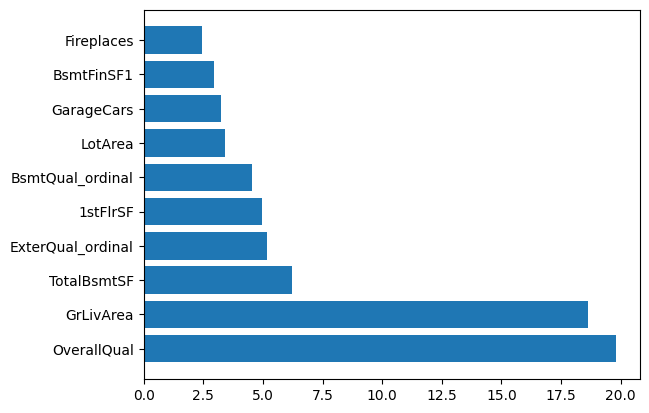

In [68]:
temp = cb_feature_importance_final.iloc[:10,]
plt.barh(temp["feature"], temp["importance_cb_5fk"]);

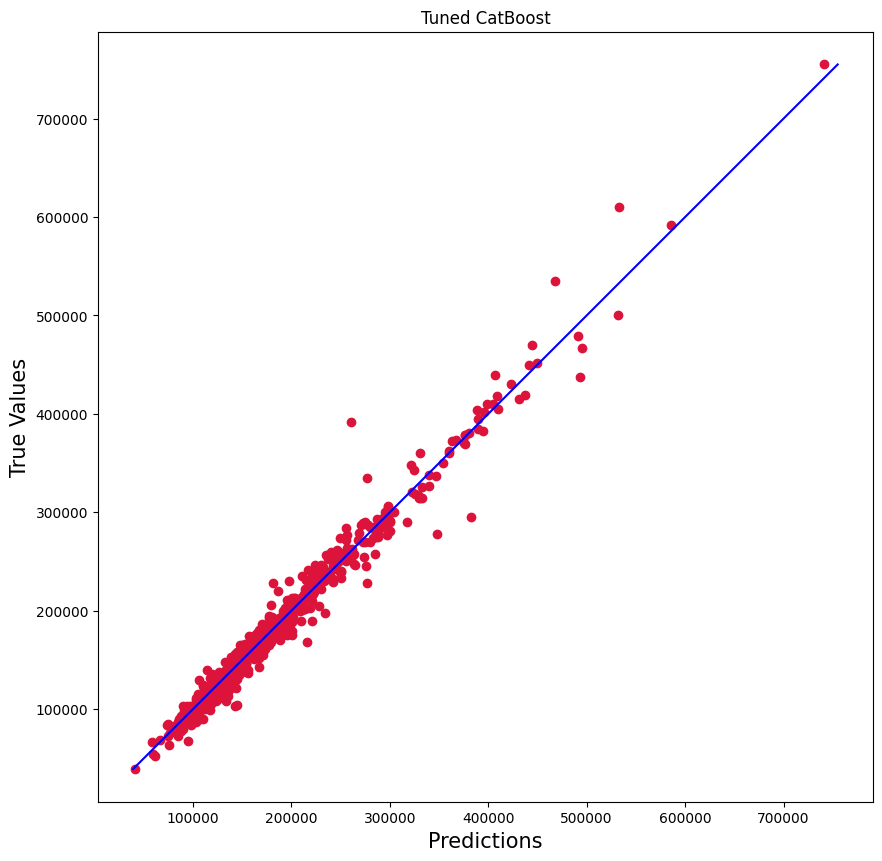

In [69]:
plt.figure(figsize=(10,10))
plt.scatter(y_test_pred, y_test, c='crimson')

plt.title('Tuned CatBoost')
p1 = max(max(y_test_pred), max(y_test))
p2 = min(min(y_test_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Predictions', fontsize=15)
plt.ylabel('True Values', fontsize=15)
plt.axis('equal')
plt.show()

## Ditch below and add model evaluation session:

That's an excellent question. You're thinking about the stability and reliability of your final model, which is a critical part of the machine learning workflow.

You've already established a strong process for building and evaluating a single, well-tuned model. To go a step further and test its stability, you can use a technique called **bootstrap aggregation**, which is at the heart of models like Random Forest. You can also explore residual plots and other error metrics to gain a deeper understanding of your model's weaknesses.

---

### Method 1: Bootstrap Aggregation (Bootstrapping)

Bootstrapping is a resampling technique that involves repeatedly drawing random samples **with replacement** from your dataset. You can use this to train multiple models and see how stable your performance metric (like RMSE) is across these different training sets. This tells you how sensitive your model's performance is to the specific data it's trained on.

Here's how to do it:

1.  **Loop and Resample**: Create a loop that runs, say, 100 times.
2.  **Draw a Sample**: In each iteration, take a bootstrap sample of your training data. The size of this sample should be equal to the size of your original training data.
3.  **Train and Evaluate**: For each sample, train a new CatBoost model using the best hyperparameters you found earlier.
4.  **Store the Score**: Evaluate this new model on your held-out test set and store the RMSE.
5.  **Analyze the Distribution**: After the loop finishes, you'll have a distribution of 100 RMSE scores.

By analyzing the distribution of these scores, you can get:

* **Average Performance**: The mean of the distribution gives you an even more robust estimate of your model's expected performance.
* **Performance Stability**: The standard deviation of the scores tells you how much the model's performance varies with different training data. A small standard deviation indicates a very stable model.

### Method 2: Residual Analysis

Another powerful way to test the stability and understand the behavior of your final model is to perform a **residual analysis**. Residuals are the differences between the actual house prices and your model's predicted prices ($residuals = y_{actual} - y_{predicted}$).

By plotting the residuals, you can identify patterns where your model might be systematically making errors.

1.  **Plot Residuals vs. Predicted Values**: A common plot is a scatter plot with predicted values on the x-axis and residuals on the y-axis.
    * **Ideal Plot**: The points should be randomly scattered around the zero line, forming a uniform band. This indicates that your model's errors are random and not dependent on the predicted price.
    * **Warning Signs**: If you see a pattern (e.g., a "fanning out" shape where residuals get larger for higher-priced houses), it means your model is less accurate for certain price ranges. This could indicate a need for more data, different features, or a more complex model. 

2.  **Plot Residuals vs. Features**: Plotting residuals against your features can reveal if your model is consistently under- or over-predicting for specific feature values. For example, plotting residuals against `GrLivArea` might show that your model consistently under-predicts the price for very large homes.

---

### Other Metrics and Comparisons

Finally, beyond RMSE, you can use other metrics to get a more complete picture of your model's performance:

* **Mean Absolute Error (MAE)**: This metric is less sensitive to outliers than RMSE. It gives you the average absolute difference between predicted and actual prices. A combination of low RMSE and MAE suggests a robust model with few large errors.
* **R-squared ($R^2$)**: While not ideal for tuning, the final $R^2$ score on the test set is an excellent way to see how much of the variance in house prices is explained by your model.
* **Baseline Comparison**: Your initial instinct was spot-on. Compare your final model's RMSE directly to your baseline model's average cross-validated RMSE. This provides a clear, quantitative measure of the value added by your hyperparameter tuning.

### Repeating K fold to find the average score

In [70]:
# here we are not changing the hyperparameter that have been determined in the CV process above
# instead of just finding the CV score by perform the 5 fold once, we repeat it multiple times and find the avg

# Define repeated CV: 5 folds, repeated 10 times (50 scores total)
rkf = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)

cv_scores = cross_val_score(final_model, X_train, y_train, cv=rkf, scoring="r2")

print('Mean CV R²:', np.mean(cv_scores))
print('Std CV R²:', np.std(cv_scores))
print('Test R²:',r2_5kf_test)

Mean CV R²: 0.9122153193490012
Std CV R²: 0.06726035414828589
Test R²: 0.9745618198708077


### Check the stability of the model by comparing fold-wise CV R square to test R square. Findings:
- Our model generalizes well because the red line is above the blue dashed line from below
- R square improved under our tuned model compared to baseline model
- If red line < blue dashed line → possible overfitting or unlucky test split.
- If blue dots are very spread out → model has high variance (performance sensitive to data splits).

NameError: name 'test_r2_baseline' is not defined

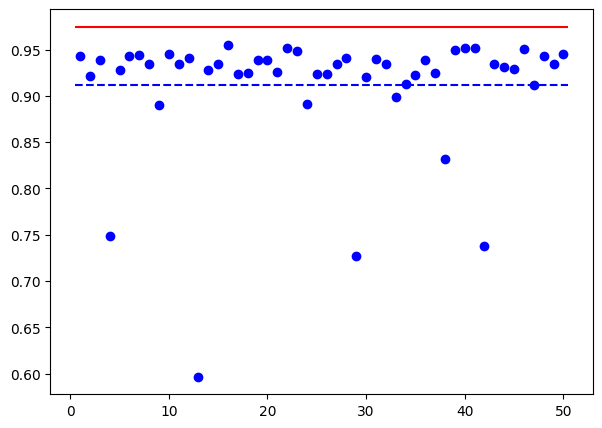

In [71]:
# plot comparison
plt.figure(figsize=(7,5))

# Plot CV fold scores
plt.scatter(range(1, len(cv_scores)+1), cv_scores, color="blue", label="CV folds")
plt.hlines(np.mean(cv_scores), 0.5, len(cv_scores)+0.5, colors="blue", linestyles="dashed", label="Mean CV R²")

# Plot test score
plt.hlines(r2_5kf_test, 0.5, len(cv_scores)+0.5, colors="red", linestyles="solid", label="Test R²")
plt.hlines(test_r2_baseline, 0.5, len(cv_scores)+0.5, colors="green", linestyles="solid", label="Test R² Baseline")

plt.xticks(range(1, len(cv_scores)+1))
plt.xlabel("CV fold")
plt.ylabel("R² score")
plt.title("Cross-validation vs. Test R²")
plt.legend()
plt.show()


### How to read below boxplot? Our model performance is consistent with CV.
- Box (blue): spread of R² across folds (median, quartiles, whiskers).
- Red dot: test R².
- If the red dot sits inside or near the box, test performance is consistent with CV.
- If the red dot is well above the box, your test set is easier.
- If the red dot is well below the box, the model may be overfitting or the test set is harder.

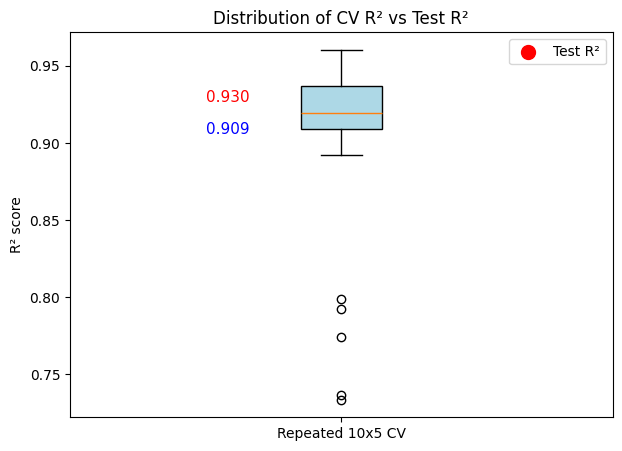

In [165]:
# visualize distribution vs test
plt.figure(figsize=(7,5))

# Boxplot of repeated CV scores
plt.boxplot(cv_scores, vert=True, patch_artist=True,
            boxprops=dict(facecolor="lightblue"))
plt.scatter(1, r2_5kf_test, color="red", s=100, marker="o", label="Test R²")

# Annotate the test R² value
plt.text(0.75, r2_5kf_test, f"{r2_5kf_test:.3f}", color="red", va="center", fontsize=11)

# Annotate mean CV R² value
cv_mean = np.mean(cv_scores)
plt.text(0.75, cv_mean, f"{cv_mean:.3f}", color="blue", va="center", fontsize=11)

# Labels
plt.xticks([1], ["Repeated 10x5 CV"])
plt.ylabel("R² score")
plt.title("Distribution of CV R² vs Test R²")
plt.legend()
plt.show()

### Test R square is within 1 SD of mean CV score

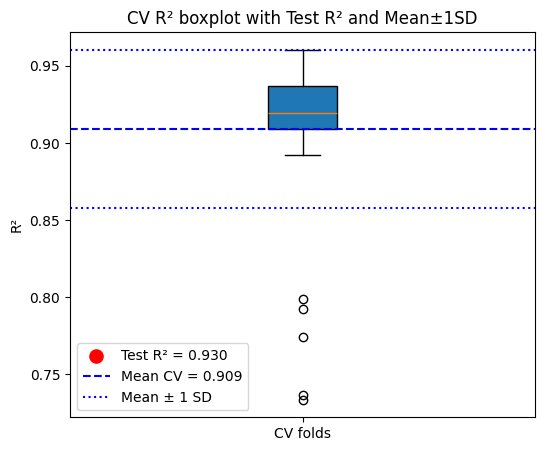

In [166]:
# import numpy as np
# import matplotlib.pyplot as plt

cv = np.array(cv_scores)           # your fold-wise R²s
test = r2_5kf_test

mean, sd = cv.mean(), cv.std(ddof=1)

plt.figure(figsize=(6,5))
plt.boxplot(cv, vert=True, patch_artist=True)
plt.scatter(1, test, s=90, color="red", label=f"Test R² = {test:.3f}")

# mean and ±1 SD lines
plt.axhline(mean, linestyle="--", color="blue", label=f"Mean CV = {mean:.3f}")
plt.axhline(mean - sd, linestyle=":", color="blue", label="Mean ± 1 SD")
plt.axhline(mean + sd, linestyle=":", color="blue")

plt.xticks([1], ["CV folds"])
plt.ylabel("R²")
plt.title("CV R² boxplot with Test R² and Mean±1SD")
plt.legend()
plt.show()

### SHAP
- A SHAP value tells you how much a particular feature pushes the model’s predicted house price up or down, compared to the average prediction across the dataset.

In [ ]:
# Say the average predicted price is $200,000
# If for House A, the SHAP value for GrLivArea is +15,000, 
# that means the model believes the GrLivArea of House A contributes +$15,000 to the price, 
# compared to the average. If for House B, the SHAP value is -5,000, 
# that means the GrLivArea of House B is lowering the prediction by $5,000 from the average.

In [167]:
import shap

# Fit explainer on train data
explainer = shap.Explainer(final_xgb)

# Evaluate SHAP values on test set
shap_values = explainer.shap_values(x_test)

#This balances accurate attribution with realistic performance evaluation.

In [169]:
# SHAP feature importance
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)

# Create a DataFrame for easier viewing and sorting
shap_importance = pd.DataFrame({
    'feature': x.columns,
    'mean_abs_shap_xgb_5fk': mean_abs_shap_values
})

# Sort in descending order
shap_importance_sorted = shap_importance.sort_values(by='mean_abs_shap_xgb_5fk', ascending=False)

# Display
print(shap_importance_sorted.head(30))

# how to interpret:
# # On average, the feature OverallQual changes the model’s prediction by 14,566 units of currency (likely dollars), 
# either increasing or decreasing the predicted house price.

                  feature  mean_abs_shap_xgb_5fk
3             OverallQual           23269.126953
0               GrLivArea           13396.876953
11            TotalBsmtSF            5408.382324
2                 LotArea            3566.944336
12               1stFlrSF            3462.946045
8              BsmtFinSF1            3389.509766
47      ExterQual_ordinal            3275.201172
24             GarageCars            3083.359863
25             GarageArea            2297.998047
41    KitchenQual_ordinal            2272.316406
5               YearBuilt            2077.958740
38    FireplaceQu_ordinal            1938.955078
4             OverallCond            1729.066284
45   BsmtFinType1_ordinal            1666.639893
6            YearRemodAdd            1478.127930
13               2ndFlrSF            1327.586914
22             Fireplaces            1176.941040
50      house_age_derived            1175.812134
44   BsmtExposure_ordinal            1027.926392
34   GarageFinish_or

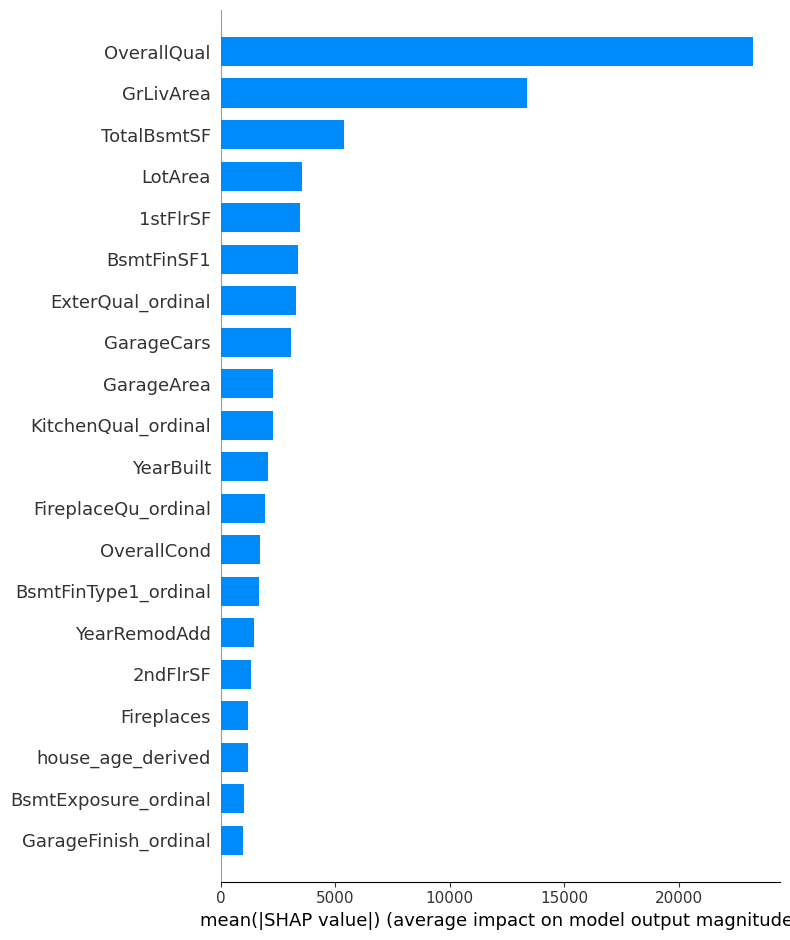

In [170]:
# to visualize the mean abs of SHAP value using summary bar plot
shap.summary_plot(shap_values, x_test, plot_type='bar')

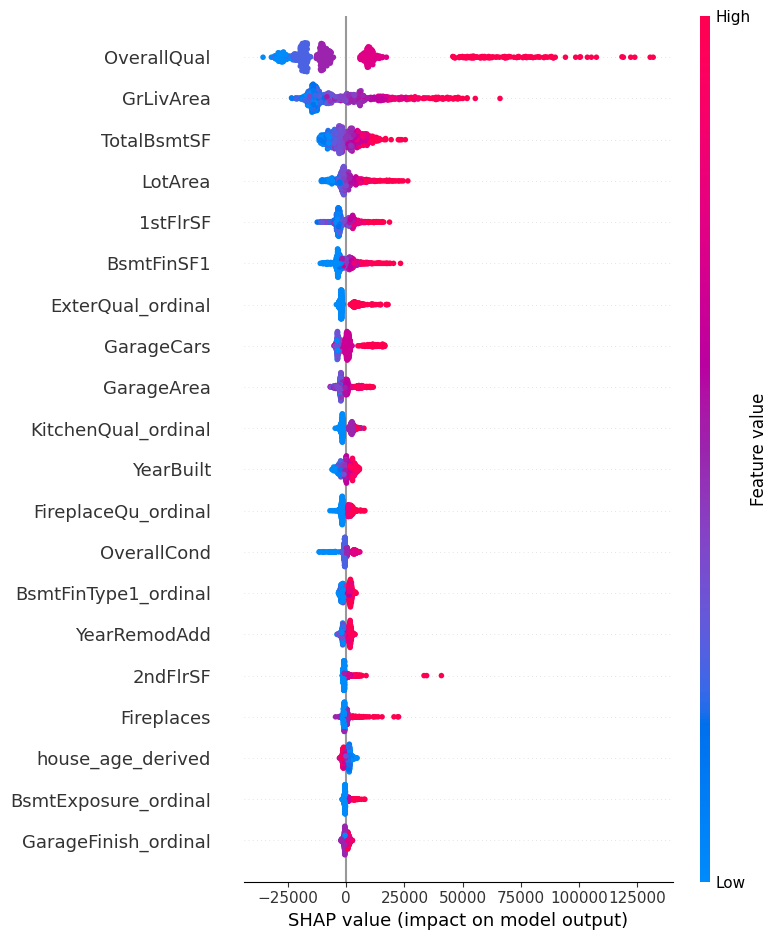

In [171]:
# summary violin plot
shap.summary_plot(shap_values, x_test)

In [ ]:
# How to Read the Violin Plot
# ✅ 1. Width of the Violin (Horizontal Spread)

# Wider areas indicate more data points with similar SHAP values.

# This shows the distribution of how much that feature affects predictions across your dataset.

# ✅ 2. Color Gradient (Red → Blue)

# Each dot is colored by the actual value of the feature:

# Red = High feature value

# Blue = Low feature value

# This helps you understand the direction of the effect.

# For example, if red dots are mostly on the right (positive SHAP values), high values of that feature increase the prediction (e.g., higher price).

# If blue dots are on the left (negative SHAP values), low values decrease the prediction.

# ✅ 3. X-Axis (SHAP Value)

# Represents the magnitude and direction of impact on the model’s prediction.

# A value of +5000 means the feature adds $5,000 (for a house price model).

# A value of -3000 means it subtracts $3,000 from the prediction.

### SHAP Dependence Plot
- In a SHAP dependence plot, the x-axis shows the value of the feature you specified, and the y-axis shows the SHAP value (i.e., the feature’s contribution to the model output). But if you’re seeing a second feature encoded on the plot, that’s expected and by design. The second feature (by color) is there to show interactions. The SHAP dependence plot automatically colors the points by the most correlated feature with the one on the x-axis. This helps uncover interactions between features.

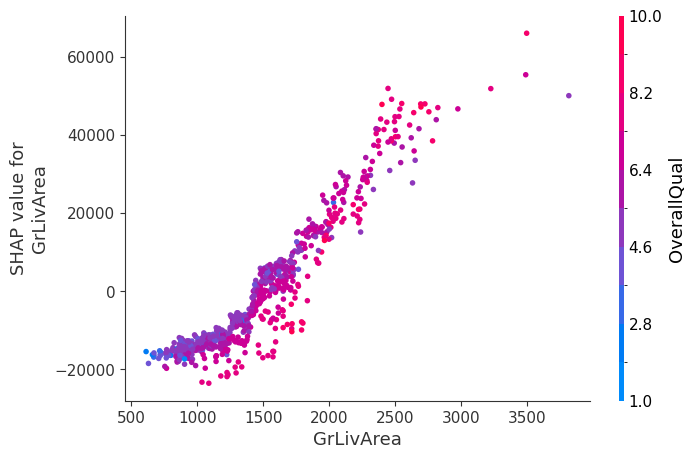

In [172]:
shap.dependence_plot('GrLivArea', shap_values, x_test)

# if don't want to show the second y-axis
#shap.dependence_plot('GrLivArea', shap_values, x_test, interaction_index=None)

<Figure size 600x400 with 0 Axes>

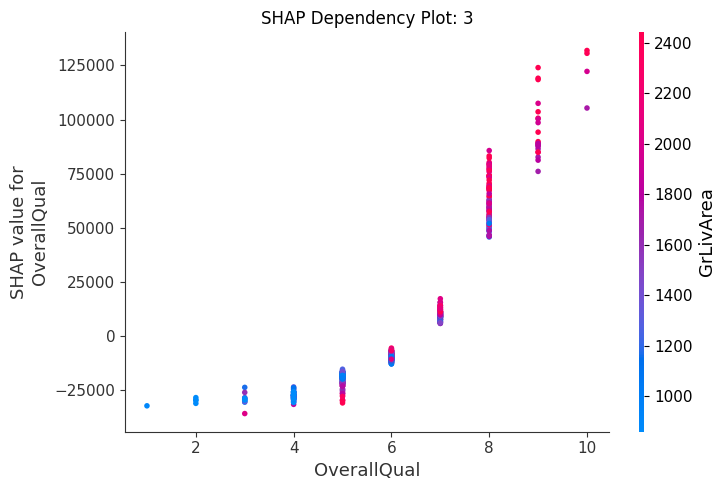

<Figure size 600x400 with 0 Axes>

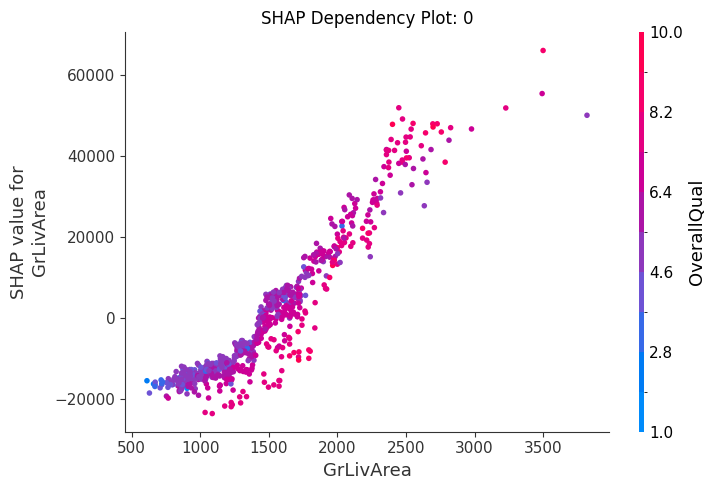

<Figure size 600x400 with 0 Axes>

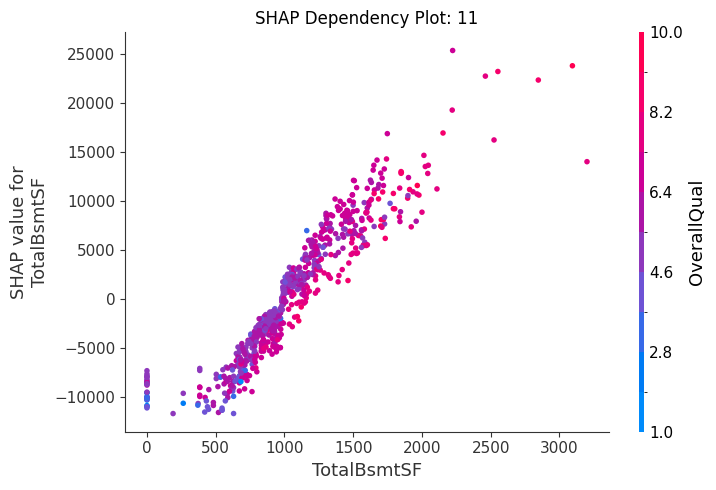

<Figure size 600x400 with 0 Axes>

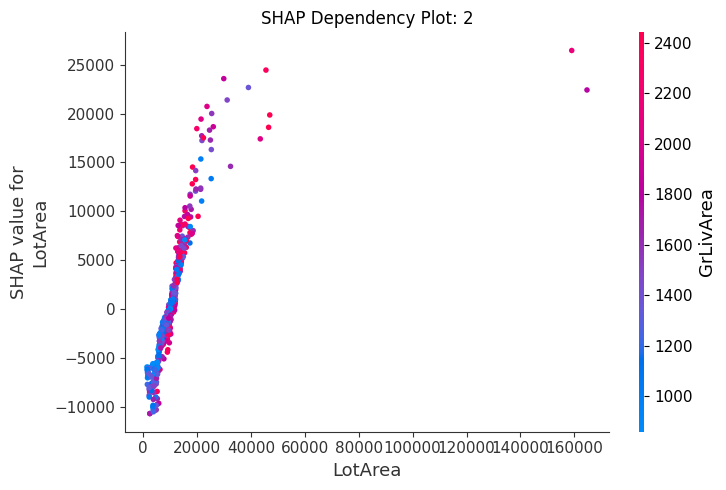

<Figure size 600x400 with 0 Axes>

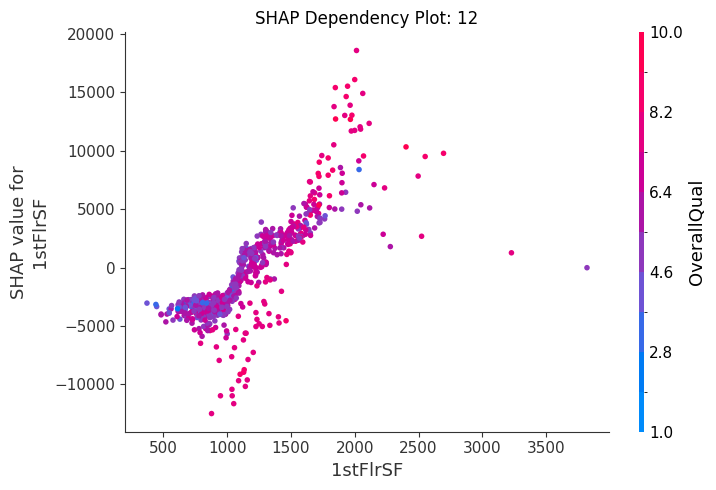

<Figure size 600x400 with 0 Axes>

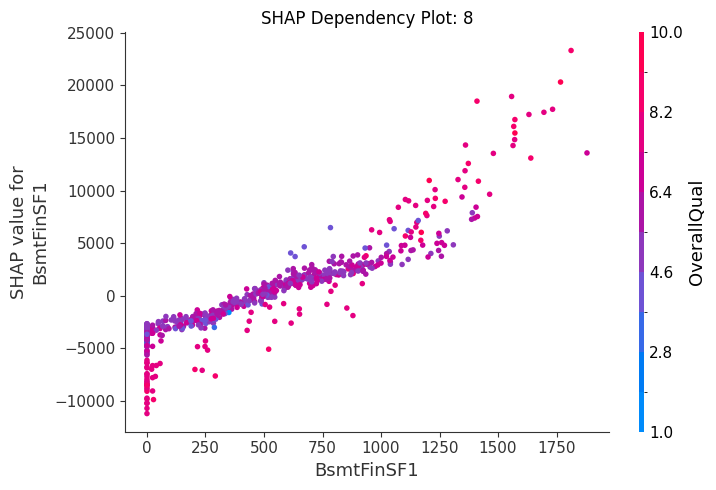

<Figure size 600x400 with 0 Axes>

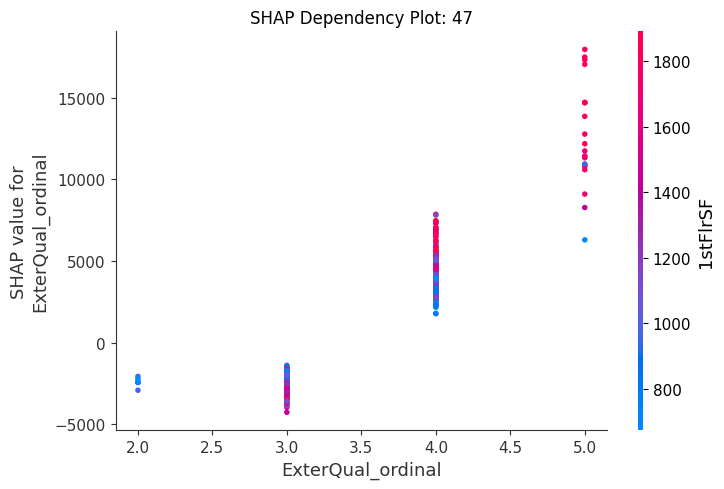

<Figure size 600x400 with 0 Axes>

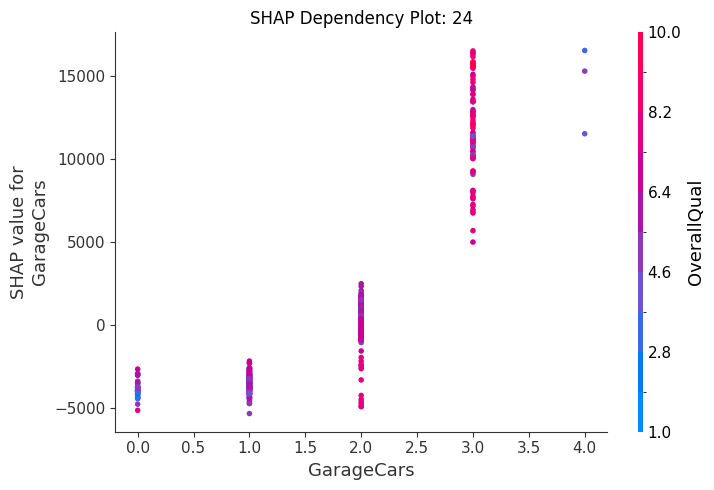

<Figure size 600x400 with 0 Axes>

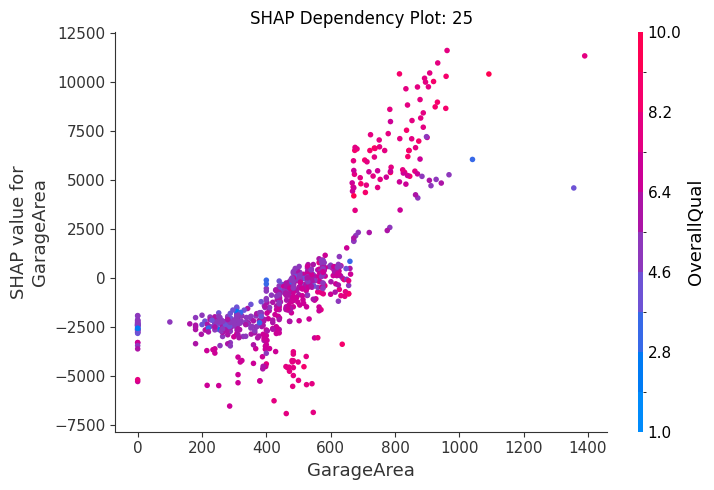

<Figure size 600x400 with 0 Axes>

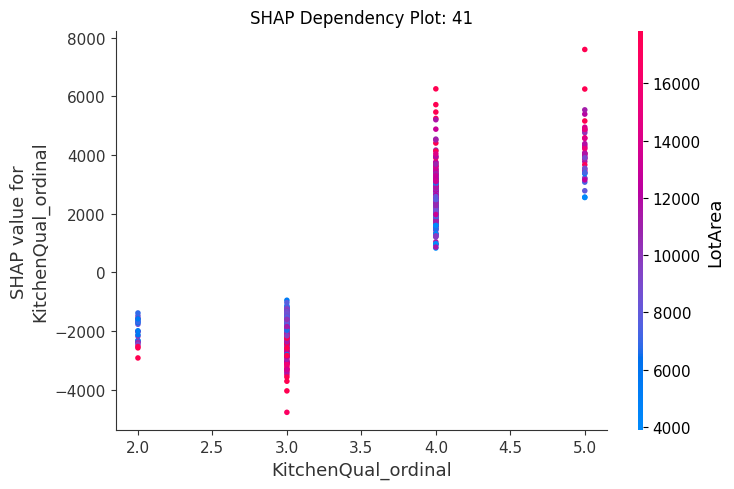

<Figure size 600x400 with 0 Axes>

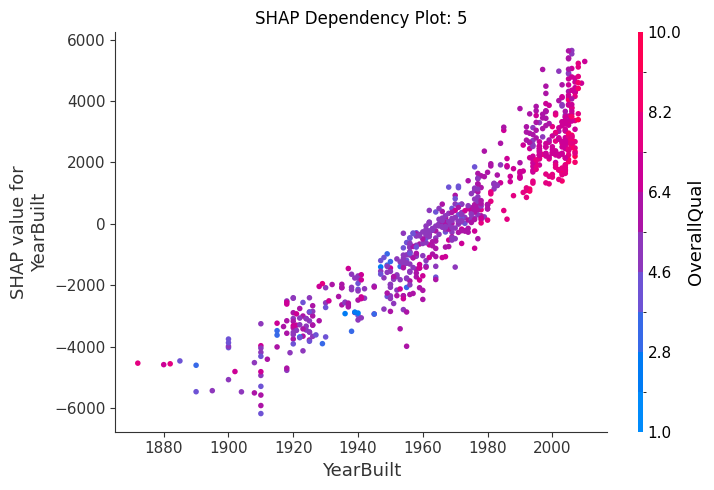

<Figure size 600x400 with 0 Axes>

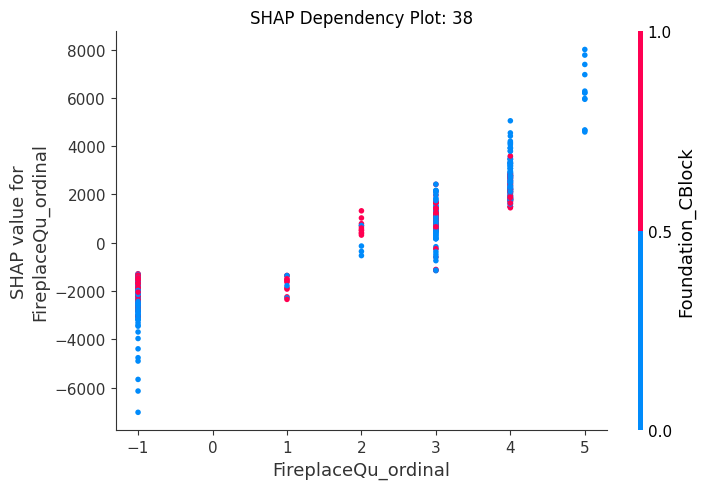

<Figure size 600x400 with 0 Axes>

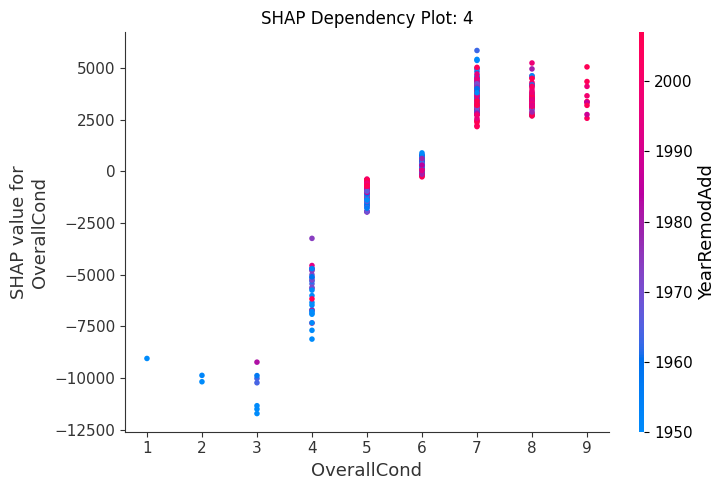

<Figure size 600x400 with 0 Axes>

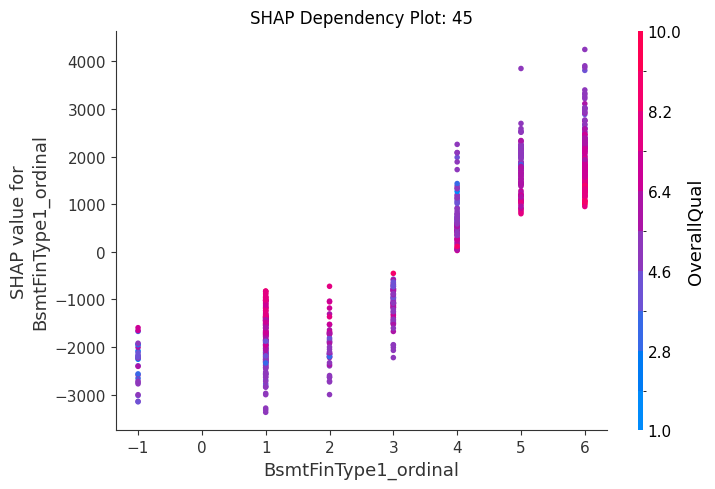

<Figure size 600x400 with 0 Axes>

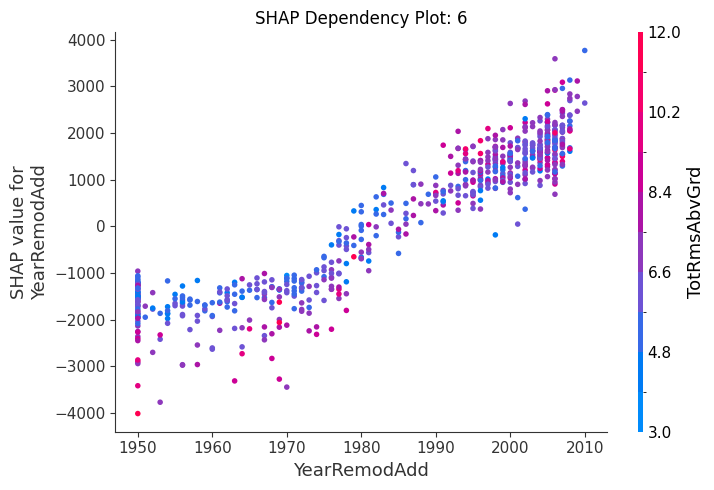

<Figure size 600x400 with 0 Axes>

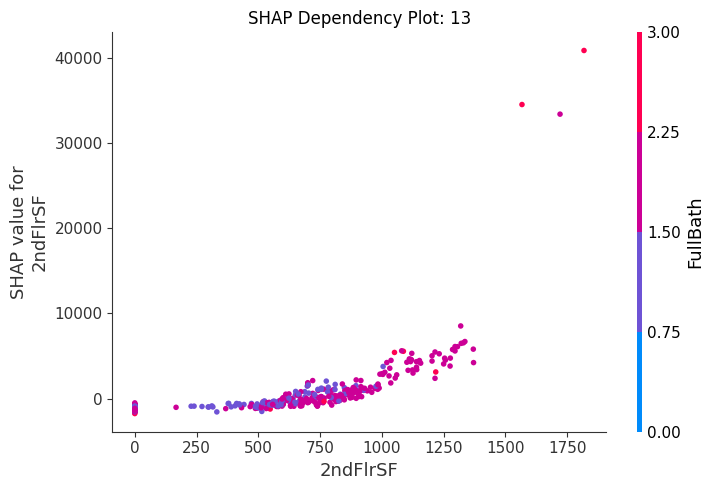

<Figure size 600x400 with 0 Axes>

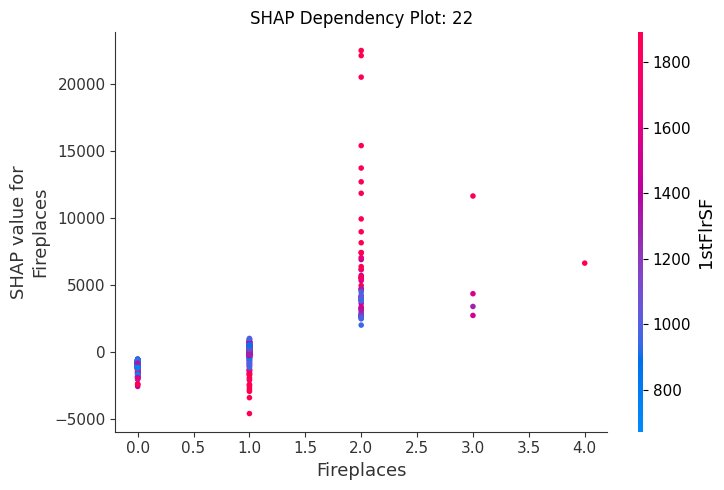

<Figure size 600x400 with 0 Axes>

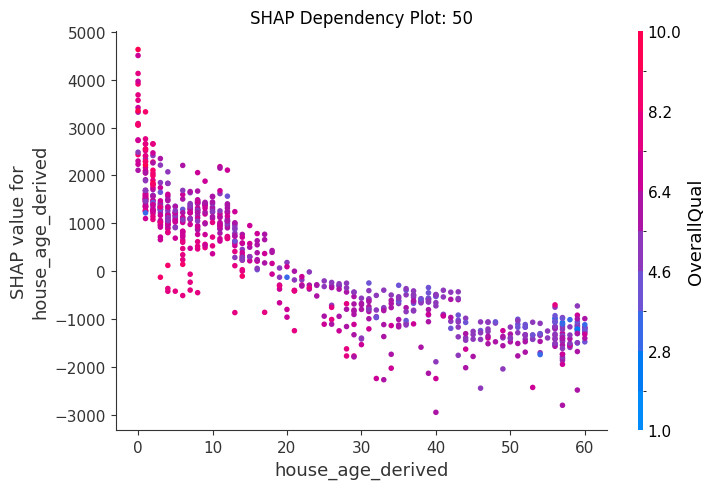

<Figure size 600x400 with 0 Axes>

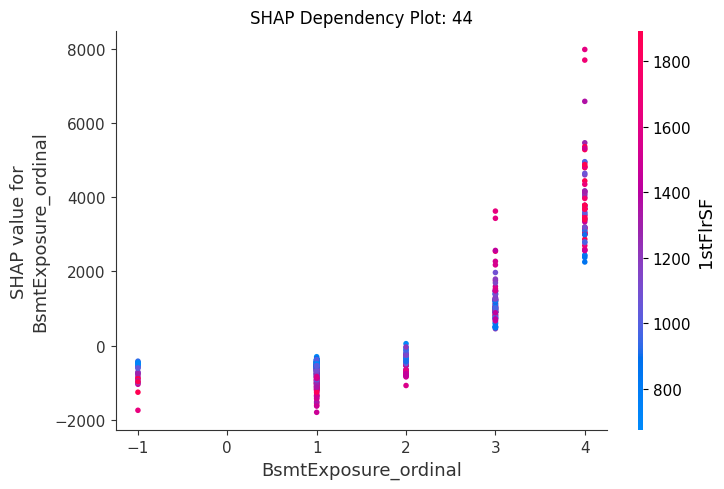

<Figure size 600x400 with 0 Axes>

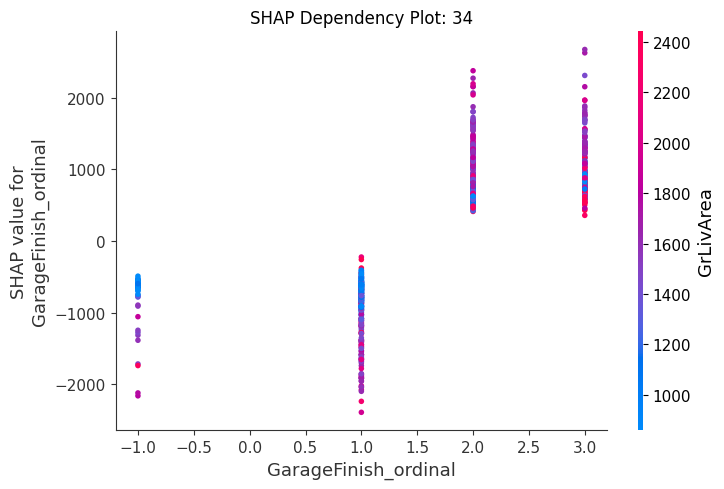

In [173]:
# Select top 20 features
top_features = shap_importance_sorted.head(20).index.tolist()

for feature in top_features:
    plt.figure(figsize=(6, 4))  # Compact size
    
    shap.dependence_plot(
        feature,
        shap_values,
        x_test,
        #interaction_index=None,  # Auto-picks a good feature for color encoding
        show=False
    )
    plt.title(f"SHAP Dependency Plot: {feature}")
    plt.tight_layout()
    plt.show()
    
    # Save plot to file
#     filename = f"shap_dependency_{feature}.png"
#     plt.savefig(filename, dpi=150)
#     plt.close()

# how to interpret
# using OverallQual as an example,
# 1stFlrSF is the most correlated feature with Overall
# you can see larger homes with high OverallQual have even higher SHAP values (strong positive synergy).
# Conversely, small homes (blue dots) with high OverallQual may still not be valued as highly.

### Export lists for final model comparison

### Extract the list of features and features that each one is most correlated with

In [174]:
# Compute correlation matrix for SHAP dependency plot coloring
cor_matrix = x_test.corr()

In [175]:
most_correlated = {}

for feature in x_test.columns:
    # Exclude self-correlation
    corrs = cor_matrix[feature].drop(labels=[feature])
    
    # Drop NaNs
    corrs = corrs.dropna()
    
    # Get feature with highest absolute correlation
    if not corrs.empty:
        most_correlated_feature = corrs.abs().idxmax()
        most_correlated[feature] = most_correlated_feature


In [176]:
correlation_df = pd.DataFrame.from_dict(most_correlated, orient='index', columns=['Most_Correlated_Feature'])
correlation_df.reset_index(inplace=True)
correlation_df.columns = ['feature', 'most_correlated_feature_xgb_5fk']

In [177]:
correlation_df

,feature,most_correlated_feature_xgb_5fk
0,GrLivArea,TotRmsAbvGrd
1,LotFrontage,1stFlrSF
2,LotArea,Street_Pave
3,OverallQual,ExterQual_ordinal
4,OverallCond,YearBuilt
...,...,...
227,Electrical_FuseP,LotShape_IR3
228,Electrical_SBrkr,CentralAir_Y
229,QrtSold_Q2,QrtSold_Q3
230,QrtSold_Q3,MoSold_7


In [178]:
# limit the above list to top 20 features ranked by mean abs SHAP values
xgb_SHAP_feature_final = pd.merge(
    shap_importance_sorted, 
    correlation_df, 
    how='left',
    on = 'feature'
)

xgb_SHAP_feature_final

,feature,mean_abs_shap_xgb_5fk,most_correlated_feature_xgb_5fk
0,OverallQual,23269.126953,ExterQual_ordinal
1,GrLivArea,13396.876953,TotRmsAbvGrd
2,TotalBsmtSF,5408.382324,1stFlrSF
3,LotArea,3566.944336,Street_Pave
4,1stFlrSF,3462.946045,TotalBsmtSF
...,...,...,...
276,exterior_covering_MetalSd_HdBoard,0.000000,condition_Feedr_Norm
277,exterior_covering_MetalSd_Stucco,0.000000,Heating_GasW
278,exterior_covering_MetalSd_VinylSd,0.000000,Neighborhood_SWISU
279,exterior_covering_MetalSd_Wd Sdng,0.000000,NaN


In [179]:
xgb_feature_importance_final

,feature,importance_xgb_5fk
24,GarageCars,0.262229
3,OverallQual,0.212933
47,ExterQual_ordinal,0.112570
42,BsmtQual_ordinal,0.042960
0,GrLivArea,0.026702
...,...,...
152,exterior_covering_Plywood_HdBoard,0.000000
153,exterior_covering_Plywood_ImStucc,0.000000
154,exterior_covering_Plywood_VinylSd,0.000000
155,exterior_covering_Plywood_Wd Sdng,0.000000
